In [306]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Loading data

In [307]:
DATA_PATH = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv'

# Adjust these column names as needed.
date_col = 'time'
target_col = 'KarupBro'
# List of meteorological features from DMI – update if needed.
input_cols = [
    'temp_min_daily', 'temp_max_daily', 'temp_mean_daily', 
    'temp_grass_mean_daily', 'temp_soil_min_daily', 'temp_soil_max_daily', 
    'temp_soil_mean_daily', 'humidity_daily', 'wind_direction_daily', 
    'wind_speed_daily', 'wind_gust_max_daily', 'precip_total_daily', 
    'precip_duration_daily', 'radiation_global_daily', 
    'sunshine_duration_daily'
]


# Read the CSV
df = pd.read_csv(DATA_PATH, parse_dates=[date_col])
df.sort_values(date_col, inplace=True)
df.reset_index(drop=True, inplace=True)

# Optional: Set the date column as index (if needed)
df.set_index(date_col, inplace=True)

df.tail()

,temp_min_daily,temp_max_daily,temp_mean_daily,temp_grass_mean_daily,temp_soil_min_daily,temp_soil_max_daily,temp_soil_mean_daily,humidity_daily,wind_direction_daily,wind_speed_daily,wind_gust_max_daily,precip_total_daily,precip_duration_daily,radiation_global_daily,sunshine_duration_daily,KarupBro
time,,,,,,,,,,,,,,,,
2024-12-27,4.0,6.0,5.250000,2.016421,6.6,7.4,6.941667,97.250000,223.583333,1.966667,6.0,0.0,0.0,131.0,12.0,NaN
2024-12-28,3.3,5.1,4.116667,1.946083,6.1,6.9,6.445833,97.666667,217.708333,3.050000,7.7,0.0,0.0,188.0,25.0,NaN
2024-12-29,4.5,8.4,7.133333,1.524006,6.1,7.4,6.812500,91.958333,231.291667,6.154167,15.4,0.1,0.0,210.0,26.0,NaN
2024-12-30,7.7,8.9,8.179167,2.204877,7.1,7.9,7.466667,91.041667,236.416667,8.741667,16.7,2.9,0.0,87.0,0.0,NaN
2024-12-31,7.9,8.6,8.300000,1.909754,7.5,7.8,7.600000,85.000000,261.000000,9.400000,16.4,0.0,0.0,0.0,0.0,NaN


In [308]:
# Check for missing values
df.isnull().sum()

temp_min_daily               0
temp_max_daily               0
temp_mean_daily              0
temp_grass_mean_daily        0
temp_soil_min_daily          0
temp_soil_max_daily          0
temp_soil_mean_daily         0
humidity_daily               0
wind_direction_daily         0
wind_speed_daily             0
wind_gust_max_daily          0
precip_total_daily           0
precip_duration_daily        0
radiation_global_daily       0
sunshine_duration_daily      0
KarupBro                   366
dtype: int64

In [309]:
# Forward fill and check again
df = df.iloc[:-366]
df.isnull().sum()

temp_min_daily             0
temp_max_daily             0
temp_mean_daily            0
temp_grass_mean_daily      0
temp_soil_min_daily        0
temp_soil_max_daily        0
temp_soil_mean_daily       0
humidity_daily             0
wind_direction_daily       0
wind_speed_daily           0
wind_gust_max_daily        0
precip_total_daily         0
precip_duration_daily      0
radiation_global_daily     0
sunshine_duration_daily    0
KarupBro                   0
dtype: int64

## Filtering data to simple model

In [310]:
df_simple = df[["temp_mean_daily", "precip_total_daily", "KarupBro"]]
df_simple.head()

,temp_mean_daily,precip_total_daily,KarupBro
time,,,
2002-01-01,1.250000,2.2,1829.75
2002-01-02,-0.837500,0.0,7279.46
2002-01-03,-5.166667,0.0,5261.85
2002-01-04,-6.025000,0.0,2951.97
2002-01-05,-3.466667,0.1,1868.53


<Axes: xlabel='time'>

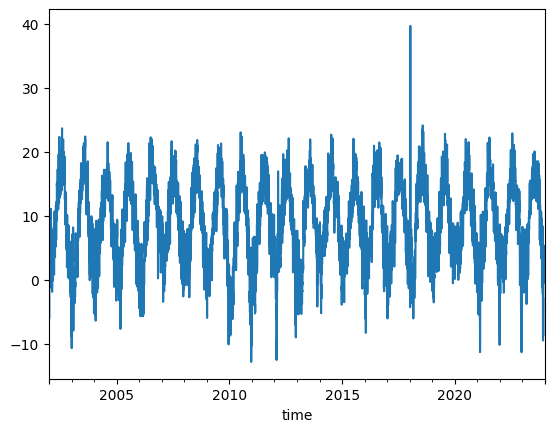

In [311]:
temp = df['temp_mean_daily']
temp.plot()

In [312]:
# Replace outliers with NaN
df.loc[df["temp_mean_daily"] > 35, "temp_mean_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["temp_mean_daily"] = df["temp_mean_daily"].ffill()

<Axes: xlabel='time'>

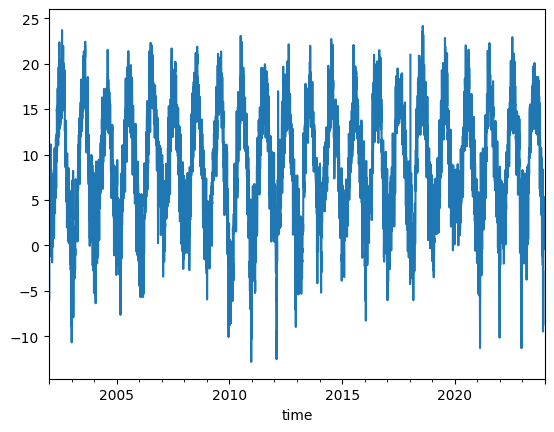

In [313]:
temp.plot()

<Axes: xlabel='time'>

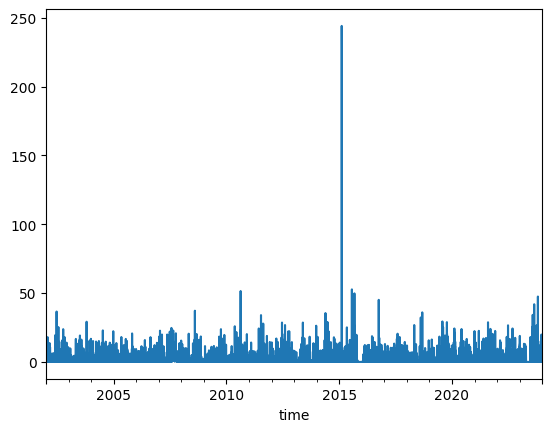

In [314]:
rain = df['precip_total_daily']
rain.plot()

In [315]:
import numpy as np

# Replace outliers with NaN
df.loc[df["precip_total_daily"] > 100, "precip_total_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["precip_total_daily"] = df["precip_total_daily"].ffill()

<Axes: xlabel='time'>

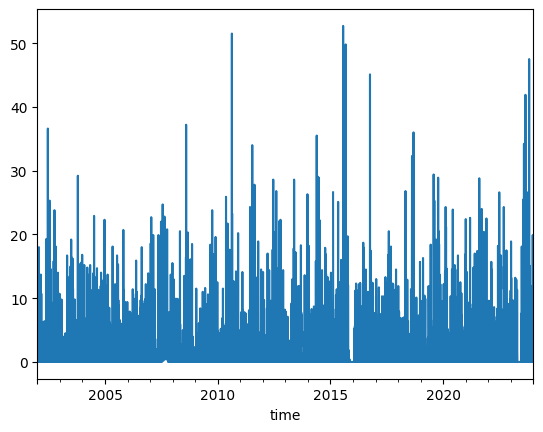

In [316]:
rain.plot()

<Axes: xlabel='time'>

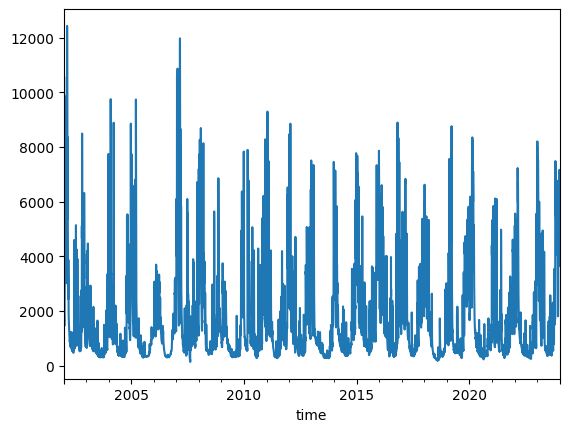

In [317]:
inflow = df['KarupBro']
inflow.plot()

In [318]:
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [319]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(inflow, WINDOW_SIZE)
X1.shape, y1.shape

((8030, 5, 1), (8030,))

In [320]:
X_train1, y_train1 = X1[:6000], y1[:6000]
X_val1, y_val1 = X1[6000:7000], y1[6000:7000]
X_test1, y_test1 = X1[7000:], y1[7000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((6000, 5, 1), (6000,), (1000, 5, 1), (1000,), (1030, 5, 1), (1030,))

In [321]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 64)                16896     
                                                                 
 dense_50 (Dense)            (None, 8)                 520       
                                                                 
 dense_51 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [322]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [323]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp1])

Epoch 1/50
165/188 [=========================>....] - ETA: 0s - loss: 5479535.5000 - root_mean_squared_error: 2340.8408INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 3s 8ms/step - loss: 5477726.0000 - root_mean_squared_error: 2340.4543 - val_loss: 5524585.0000 - val_root_mean_squared_error: 2350.4436
Epoch 2/50
177/188 [===========================>..] - ETA: 0s - loss: 5476320.5000 - root_mean_squared_error: 2340.1541INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5477109.0000 - root_mean_squared_error: 2340.3225 - val_loss: 5524005.0000 - val_root_mean_squared_error: 2350.3203
Epoch 3/50
174/188 [==========================>...] - ETA: 0s - loss: 5507504.5000 - root_mean_squared_error: 2346.8074INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5476495.0000 - root_mean_squared_error: 2340.1912 - val_loss: 5523425.5000 - val_root_mean_squared_error: 2350.1970
Epoch 4/50
164/188 [=========================>....] - ETA: 0s - loss: 5461845.5000 - root_mean_squared_error: 2337.0591INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5475884.5000 - root_mean_squared_error: 2340.0608 - val_loss: 5522846.0000 - val_root_mean_squared_error: 2350.0737
Epoch 5/50
164/188 [=========================>....] - ETA: 0s - loss: 5552846.5000 - root_mean_squared_error: 2356.4478INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5475272.5000 - root_mean_squared_error: 2339.9299 - val_loss: 5522267.0000 - val_root_mean_squared_error: 2349.9504
Epoch 6/50
165/188 [=========================>....] - ETA: 0s - loss: 5519315.0000 - root_mean_squared_error: 2349.3223INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5474661.5000 - root_mean_squared_error: 2339.7996 - val_loss: 5521689.0000 - val_root_mean_squared_error: 2349.8274
Epoch 7/50
162/188 [========================>.....] - ETA: 0s - loss: 5446618.5000 - root_mean_squared_error: 2333.7991INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5474048.5000 - root_mean_squared_error: 2339.6685 - val_loss: 5521110.5000 - val_root_mean_squared_error: 2349.7043
Epoch 8/50
170/188 [==========================>...] - ETA: 0s - loss: 5527799.5000 - root_mean_squared_error: 2351.1272INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5473439.0000 - root_mean_squared_error: 2339.5381 - val_loss: 5520532.0000 - val_root_mean_squared_error: 2349.5813
Epoch 9/50
160/188 [========================>.....] - ETA: 0s - loss: 5532179.5000 - root_mean_squared_error: 2352.0586INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 10ms/step - loss: 5472827.0000 - root_mean_squared_error: 2339.4075 - val_loss: 5519955.5000 - val_root_mean_squared_error: 2349.4585
Epoch 10/50
178/188 [===========================>..] - ETA: 0s - loss: 5452683.5000 - root_mean_squared_error: 2335.0981INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5472217.0000 - root_mean_squared_error: 2339.2771 - val_loss: 5519378.0000 - val_root_mean_squared_error: 2349.3357
Epoch 11/50
176/188 [===========================>..] - ETA: 0s - loss: 5426843.5000 - root_mean_squared_error: 2329.5586INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5471606.0000 - root_mean_squared_error: 2339.1465 - val_loss: 5518799.0000 - val_root_mean_squared_error: 2349.2124
Epoch 12/50
178/188 [===========================>..] - ETA: 0s - loss: 5474787.0000 - root_mean_squared_error: 2339.8262INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5470995.0000 - root_mean_squared_error: 2339.0159 - val_loss: 5518219.0000 - val_root_mean_squared_error: 2349.0889
Epoch 13/50
166/188 [=========================>....] - ETA: 0s - loss: 5483591.0000 - root_mean_squared_error: 2341.7068INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5470382.5000 - root_mean_squared_error: 2338.8848 - val_loss: 5517643.5000 - val_root_mean_squared_error: 2348.9666
Epoch 14/50
180/188 [===========================>..] - ETA: 0s - loss: 5494553.0000 - root_mean_squared_error: 2344.0464INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5469774.0000 - root_mean_squared_error: 2338.7549 - val_loss: 5517067.0000 - val_root_mean_squared_error: 2348.8438
Epoch 15/50
181/188 [===========================>..] - ETA: 0s - loss: 5480752.5000 - root_mean_squared_error: 2341.1006INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5469167.5000 - root_mean_squared_error: 2338.6252 - val_loss: 5516491.0000 - val_root_mean_squared_error: 2348.7212
Epoch 16/50
180/188 [===========================>..] - ETA: 0s - loss: 5471725.5000 - root_mean_squared_error: 2339.1719INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5468558.0000 - root_mean_squared_error: 2338.4949 - val_loss: 5515913.5000 - val_root_mean_squared_error: 2348.5981
Epoch 17/50
178/188 [===========================>..] - ETA: 0s - loss: 5429804.5000 - root_mean_squared_error: 2330.1941INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5467944.5000 - root_mean_squared_error: 2338.3635 - val_loss: 5515336.5000 - val_root_mean_squared_error: 2348.4753
Epoch 18/50
180/188 [===========================>..] - ETA: 0s - loss: 5444575.5000 - root_mean_squared_error: 2333.3613INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 11ms/step - loss: 5467335.5000 - root_mean_squared_error: 2338.2334 - val_loss: 5514759.5000 - val_root_mean_squared_error: 2348.3525
Epoch 19/50
179/188 [===========================>..] - ETA: 0s - loss: 5520438.0000 - root_mean_squared_error: 2349.5613INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5466727.0000 - root_mean_squared_error: 2338.1033 - val_loss: 5514182.0000 - val_root_mean_squared_error: 2348.2295
Epoch 20/50
179/188 [===========================>..] - ETA: 0s - loss: 5481305.0000 - root_mean_squared_error: 2341.2188INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5466118.0000 - root_mean_squared_error: 2337.9731 - val_loss: 5513606.0000 - val_root_mean_squared_error: 2348.1069
Epoch 21/50
175/188 [==========================>...] - ETA: 0s - loss: 5386767.5000 - root_mean_squared_error: 2320.9412INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5465510.0000 - root_mean_squared_error: 2337.8430 - val_loss: 5513032.0000 - val_root_mean_squared_error: 2347.9846
Epoch 22/50
177/188 [===========================>..] - ETA: 0s - loss: 5402406.5000 - root_mean_squared_error: 2324.3079INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5464901.0000 - root_mean_squared_error: 2337.7129 - val_loss: 5512456.5000 - val_root_mean_squared_error: 2347.8621
Epoch 23/50
174/188 [==========================>...] - ETA: 0s - loss: 5422093.0000 - root_mean_squared_error: 2328.5388INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5464291.0000 - root_mean_squared_error: 2337.5823 - val_loss: 5511879.5000 - val_root_mean_squared_error: 2347.7393
Epoch 24/50
180/188 [===========================>..] - ETA: 0s - loss: 5394403.5000 - root_mean_squared_error: 2322.5854INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5463683.5000 - root_mean_squared_error: 2337.4524 - val_loss: 5511304.0000 - val_root_mean_squared_error: 2347.6167
Epoch 25/50
179/188 [===========================>..] - ETA: 0s - loss: 5452648.0000 - root_mean_squared_error: 2335.0906INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5463073.0000 - root_mean_squared_error: 2337.3218 - val_loss: 5510725.0000 - val_root_mean_squared_error: 2347.4934
Epoch 26/50
154/188 [=======================>......] - ETA: 0s - loss: 5426484.5000 - root_mean_squared_error: 2329.4817INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5462465.0000 - root_mean_squared_error: 2337.1917 - val_loss: 5510148.0000 - val_root_mean_squared_error: 2347.3704
Epoch 27/50
168/188 [=========================>....] - ETA: 0s - loss: 5511663.5000 - root_mean_squared_error: 2347.6931INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 11ms/step - loss: 5461855.5000 - root_mean_squared_error: 2337.0613 - val_loss: 5509572.0000 - val_root_mean_squared_error: 2347.2478
Epoch 28/50
178/188 [===========================>..] - ETA: 0s - loss: 5467910.0000 - root_mean_squared_error: 2338.3562INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5461250.0000 - root_mean_squared_error: 2336.9316 - val_loss: 5508997.5000 - val_root_mean_squared_error: 2347.1255
Epoch 29/50
181/188 [===========================>..] - ETA: 0s - loss: 5413791.0000 - root_mean_squared_error: 2326.7554INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5460639.0000 - root_mean_squared_error: 2336.8010 - val_loss: 5508422.5000 - val_root_mean_squared_error: 2347.0029
Epoch 30/50
178/188 [===========================>..] - ETA: 0s - loss: 5447695.0000 - root_mean_squared_error: 2334.0298INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5460032.5000 - root_mean_squared_error: 2336.6711 - val_loss: 5507844.5000 - val_root_mean_squared_error: 2346.8796
Epoch 31/50
180/188 [===========================>..] - ETA: 0s - loss: 5467339.0000 - root_mean_squared_error: 2338.2341INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5459423.0000 - root_mean_squared_error: 2336.5408 - val_loss: 5507269.5000 - val_root_mean_squared_error: 2346.7573
Epoch 32/50
174/188 [==========================>...] - ETA: 0s - loss: 5382432.0000 - root_mean_squared_error: 2320.0068INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5458813.0000 - root_mean_squared_error: 2336.4104 - val_loss: 5506693.0000 - val_root_mean_squared_error: 2346.6343
Epoch 33/50
157/188 [========================>.....] - ETA: 0s - loss: 5416470.0000 - root_mean_squared_error: 2327.3311INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5458202.5000 - root_mean_squared_error: 2336.2795 - val_loss: 5506118.0000 - val_root_mean_squared_error: 2346.5120
Epoch 34/50
180/188 [===========================>..] - ETA: 0s - loss: 5451444.5000 - root_mean_squared_error: 2334.8328INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5457595.5000 - root_mean_squared_error: 2336.1497 - val_loss: 5505542.0000 - val_root_mean_squared_error: 2346.3892
Epoch 35/50
179/188 [===========================>..] - ETA: 0s - loss: 5387680.0000 - root_mean_squared_error: 2321.1377INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5456985.0000 - root_mean_squared_error: 2336.0190 - val_loss: 5504967.5000 - val_root_mean_squared_error: 2346.2666
Epoch 36/50
165/188 [=========================>....] - ETA: 0s - loss: 5537168.0000 - root_mean_squared_error: 2353.1189INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5456377.0000 - root_mean_squared_error: 2335.8889 - val_loss: 5504388.0000 - val_root_mean_squared_error: 2346.1433
Epoch 37/50
170/188 [==========================>...] - ETA: 0s - loss: 5539406.5000 - root_mean_squared_error: 2353.5945INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 11ms/step - loss: 5455769.0000 - root_mean_squared_error: 2335.7588 - val_loss: 5503813.0000 - val_root_mean_squared_error: 2346.0208
Epoch 38/50
178/188 [===========================>..] - ETA: 0s - loss: 5475840.5000 - root_mean_squared_error: 2340.0513INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5455161.0000 - root_mean_squared_error: 2335.6287 - val_loss: 5503239.5000 - val_root_mean_squared_error: 2345.8984
Epoch 39/50
180/188 [===========================>..] - ETA: 0s - loss: 5475719.0000 - root_mean_squared_error: 2340.0254INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5454555.0000 - root_mean_squared_error: 2335.4988 - val_loss: 5502664.5000 - val_root_mean_squared_error: 2345.7759
Epoch 40/50
177/188 [===========================>..] - ETA: 0s - loss: 5491059.5000 - root_mean_squared_error: 2343.3010INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5453945.0000 - root_mean_squared_error: 2335.3682 - val_loss: 5502087.5000 - val_root_mean_squared_error: 2345.6528
Epoch 41/50
178/188 [===========================>..] - ETA: 0s - loss: 5451055.5000 - root_mean_squared_error: 2334.7495INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5453337.0000 - root_mean_squared_error: 2335.2380 - val_loss: 5501512.0000 - val_root_mean_squared_error: 2345.5303
Epoch 42/50
181/188 [===========================>..] - ETA: 0s - loss: 5468509.0000 - root_mean_squared_error: 2338.4844INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5452728.0000 - root_mean_squared_error: 2335.1077 - val_loss: 5500935.0000 - val_root_mean_squared_error: 2345.4072
Epoch 43/50
181/188 [===========================>..] - ETA: 0s - loss: 5496129.0000 - root_mean_squared_error: 2344.3823INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5452120.5000 - root_mean_squared_error: 2334.9775 - val_loss: 5500360.5000 - val_root_mean_squared_error: 2345.2847
Epoch 44/50
180/188 [===========================>..] - ETA: 0s - loss: 5428597.5000 - root_mean_squared_error: 2329.9351INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5451512.0000 - root_mean_squared_error: 2334.8474 - val_loss: 5499788.0000 - val_root_mean_squared_error: 2345.1626
Epoch 45/50
160/188 [========================>.....] - ETA: 0s - loss: 5477431.5000 - root_mean_squared_error: 2340.3914INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5450905.0000 - root_mean_squared_error: 2334.7173 - val_loss: 5499213.0000 - val_root_mean_squared_error: 2345.0400
Epoch 46/50
178/188 [===========================>..] - ETA: 0s - loss: 5452410.0000 - root_mean_squared_error: 2335.0396INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 2s 10ms/step - loss: 5450297.0000 - root_mean_squared_error: 2334.5872 - val_loss: 5498636.0000 - val_root_mean_squared_error: 2344.9170
Epoch 47/50
175/188 [==========================>...] - ETA: 0s - loss: 5463415.0000 - root_mean_squared_error: 2337.3950INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 7ms/step - loss: 5449690.0000 - root_mean_squared_error: 2334.4570 - val_loss: 5498062.0000 - val_root_mean_squared_error: 2344.7947
Epoch 48/50
179/188 [===========================>..] - ETA: 0s - loss: 5436458.0000 - root_mean_squared_error: 2331.6213INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5449081.0000 - root_mean_squared_error: 2334.3267 - val_loss: 5497486.5000 - val_root_mean_squared_error: 2344.6719
Epoch 49/50
179/188 [===========================>..] - ETA: 0s - loss: 5445056.5000 - root_mean_squared_error: 2333.4646INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5448473.5000 - root_mean_squared_error: 2334.1965 - val_loss: 5496911.5000 - val_root_mean_squared_error: 2344.5493
Epoch 50/50
179/188 [===========================>..] - ETA: 0s - loss: 5475748.0000 - root_mean_squared_error: 2340.0317INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


188/188 [==============================] - 1s 6ms/step - loss: 5447868.5000 - root_mean_squared_error: 2334.0669 - val_loss: 5496337.0000 - val_root_mean_squared_error: 2344.4268


In [324]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [325]:
from sklearn.metrics import root_mean_squared_error as rmse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, rmse(predictions, y)

33/33 [==============================] - 0s 777us/step


(      Predictions  Actuals
 0        9.252055  1015.35
 1        9.252055   905.19
 2        9.252055   862.98
 3        9.252055   832.00
 4        9.252055  3217.89
 ...           ...      ...
 1025     9.252055  5197.40
 1026     9.252055  6368.46
 1027     9.252055  7162.01
 1028     9.252055  6869.41
 1029     9.252055  6335.36
 
 [1030 rows x 2 columns],
 2517.656499060668)

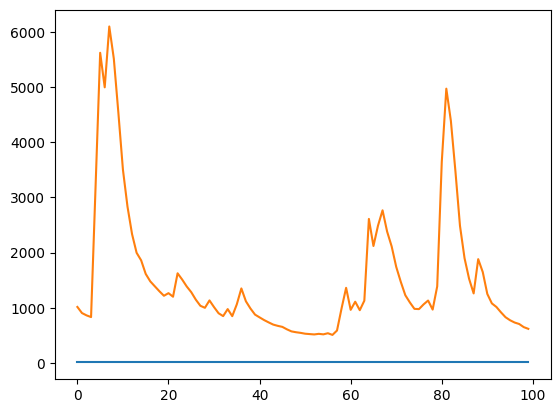

In [326]:
plot_predictions1(model1, X_test1, y_test1)

## Conv1D model

In [327]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2, activation='relu'))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))
model2.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 4, 64)             192       
                                                                 
 flatten_7 (Flatten)         (None, 256)               0         
                                                                 
 dense_52 (Dense)            (None, 8)                 2056      
                                                                 
 dense_53 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2257 (8.82 KB)
Trainable params: 2257 (8.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [328]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [329]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp2])

Epoch 1/50
186/188 [============================>.] - ETA: 0s - loss: 629704.3750 - root_mean_squared_error: 793.5391 INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 1s 2ms/step - loss: 628238.5625 - root_mean_squared_error: 792.6150 - val_loss: 172432.0938 - val_root_mean_squared_error: 415.2495
Epoch 2/50
188/188 [==============================] - 0s 586us/step - loss: 339173.4062 - root_mean_squared_error: 582.3860 - val_loss: 176916.5000 - val_root_mean_squared_error: 420.6144
Epoch 3/50
102/188 [===============>..............] - ETA: 0s - loss: 304798.9688 - root_mean_squared_error: 552.0860INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 0s 2ms/step - loss: 332940.5938 - root_mean_squared_error: 577.0101 - val_loss: 158091.2812 - val_root_mean_squared_error: 397.6069
Epoch 4/50
188/188 [==============================] - 0s 584us/step - loss: 327574.5625 - root_mean_squared_error: 572.3413 - val_loss: 169481.0938 - val_root_mean_squared_error: 411.6808
Epoch 5/50
188/188 [==============================] - 0s 603us/step - loss: 330146.4062 - root_mean_squared_error: 574.5837 - val_loss: 208014.0469 - val_root_mean_squared_error: 456.0856
Epoch 6/50
188/188 [==============================] - 0s 579us/step - loss: 323169.1875 - root_mean_squared_error: 568.4797 - val_loss: 167956.9219 - val_root_mean_squared_error: 409.8255
Epoch 7/50
188/188 [==============================] - 0s 579us/step - loss: 324026.3750 - root_mean_squared_error: 569.2332 - val_loss: 201930.2188 - val_root_mean_squared_error: 449.3665
Epoch 8/50
188/188 [==============================] - 0s 822us/step - los

INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 0s 1ms/step - loss: 322607.5625 - root_mean_squared_error: 567.9855 - val_loss: 157661.2344 - val_root_mean_squared_error: 397.0658
Epoch 12/50
117/188 [=================>............] - ETA: 0s - loss: 331604.3750 - root_mean_squared_error: 575.8510INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 0s 1ms/step - loss: 325263.5000 - root_mean_squared_error: 570.3188 - val_loss: 156835.7031 - val_root_mean_squared_error: 396.0249
Epoch 13/50
115/188 [=================>............] - ETA: 0s - loss: 311614.3438 - root_mean_squared_error: 558.2243INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 0s 1ms/step - loss: 319600.9375 - root_mean_squared_error: 565.3326 - val_loss: 152616.5781 - val_root_mean_squared_error: 390.6617
Epoch 14/50
188/188 [==============================] - 0s 569us/step - loss: 321097.0312 - root_mean_squared_error: 566.6542 - val_loss: 156192.3750 - val_root_mean_squared_error: 395.2118
Epoch 15/50
188/188 [==============================] - 0s 582us/step - loss: 320350.5312 - root_mean_squared_error: 565.9952 - val_loss: 161418.9219 - val_root_mean_squared_error: 401.7697
Epoch 16/50
188/188 [==============================] - 0s 565us/step - loss: 317872.5000 - root_mean_squared_error: 563.8018 - val_loss: 165615.8281 - val_root_mean_squared_error: 406.9593
Epoch 17/50
188/188 [==============================] - 0s 568us/step - loss: 320250.5625 - root_mean_squared_error: 565.9069 - val_loss: 157602.6406 - val_root_mean_squared_error: 396.9920
Epoch 18/50
188/188 [==============================] - 0s 574us/step 

INFO:tensorflow:Assets written to: model2/assets


188/188 [==============================] - 0s 1ms/step - loss: 315543.3750 - root_mean_squared_error: 561.7325 - val_loss: 152477.1562 - val_root_mean_squared_error: 390.4832
Epoch 24/50
188/188 [==============================] - 0s 598us/step - loss: 319663.3750 - root_mean_squared_error: 565.3878 - val_loss: 156436.1875 - val_root_mean_squared_error: 395.5201
Epoch 25/50
188/188 [==============================] - 0s 568us/step - loss: 313641.4375 - root_mean_squared_error: 560.0370 - val_loss: 162587.0156 - val_root_mean_squared_error: 403.2208
Epoch 26/50
188/188 [==============================] - 0s 569us/step - loss: 318233.9688 - root_mean_squared_error: 564.1223 - val_loss: 163728.2031 - val_root_mean_squared_error: 404.6334
Epoch 27/50
188/188 [==============================] - 0s 603us/step - loss: 316020.6875 - root_mean_squared_error: 562.1572 - val_loss: 157957.0625 - val_root_mean_squared_error: 397.4381
Epoch 28/50
188/188 [==============================] - 0s 593us/step 

33/33 [==============================] - 0s 420us/step


(      Predictions  Actuals
 0     1051.098022  1015.35
 1     1059.867432   905.19
 2      831.498291   862.98
 3      893.598572   832.00
 4      828.487549  3217.89
 ...           ...      ...
 1025  5497.067383  5197.40
 1026  4736.706055  6368.46
 1027  6907.095703  7162.01
 1028  7008.873535  6869.41
 1029  6243.403809  6335.36
 
 [1030 rows x 2 columns],
 443.8459987761913)

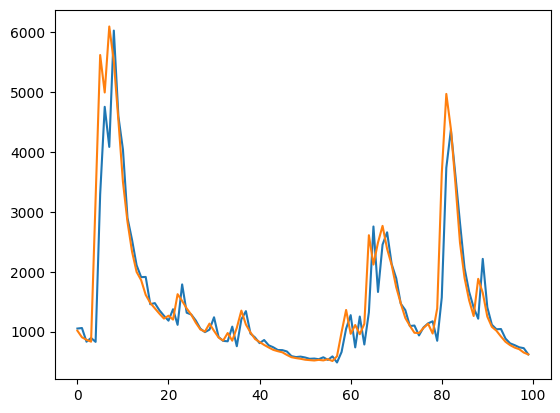

In [330]:
plot_predictions1(model2, X_test1, y_test1)

## GRU Model

In [331]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 64)                12864     
                                                                 
 dense_54 (Dense)            (None, 8)                 520       
                                                                 
 dense_55 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13393 (52.32 KB)
Trainable params: 13393 (52.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [332]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [333]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp3])

Epoch 1/50
184/188 [============================>.] - ETA: 0s - loss: 5460037.5000 - root_mean_squared_error: 2336.6724INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 2s 7ms/step - loss: 5469199.0000 - root_mean_squared_error: 2338.6318 - val_loss: 5506086.5000 - val_root_mean_squared_error: 2346.5051
Epoch 2/50
179/188 [===========================>..] - ETA: 0s - loss: 5488115.5000 - root_mean_squared_error: 2342.6726INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 2s 10ms/step - loss: 5436809.0000 - root_mean_squared_error: 2331.6965 - val_loss: 5461313.0000 - val_root_mean_squared_error: 2336.9453
Epoch 3/50
178/188 [===========================>..] - ETA: 0s - loss: 5420767.5000 - root_mean_squared_error: 2328.2542INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 5372368.0000 - root_mean_squared_error: 2317.8369 - val_loss: 5382833.5000 - val_root_mean_squared_error: 2320.0935
Epoch 4/50
179/188 [===========================>..] - ETA: 0s - loss: 5249940.5000 - root_mean_squared_error: 2291.2749INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 5274090.5000 - root_mean_squared_error: 2296.5388 - val_loss: 5277081.5000 - val_root_mean_squared_error: 2297.1899
Epoch 5/50
180/188 [===========================>..] - ETA: 0s - loss: 5116912.5000 - root_mean_squared_error: 2262.0593INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 5150679.5000 - root_mean_squared_error: 2269.5107 - val_loss: 5151307.5000 - val_root_mean_squared_error: 2269.6492
Epoch 6/50
177/188 [===========================>..] - ETA: 0s - loss: 4969215.5000 - root_mean_squared_error: 2229.1738INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 5008945.0000 - root_mean_squared_error: 2238.0671 - val_loss: 5011028.0000 - val_root_mean_squared_error: 2238.5325
Epoch 7/50
178/188 [===========================>..] - ETA: 0s - loss: 4851693.5000 - root_mean_squared_error: 2202.6560INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 4853441.0000 - root_mean_squared_error: 2203.0527 - val_loss: 4859334.5000 - val_root_mean_squared_error: 2204.3899
Epoch 8/50
175/188 [==========================>...] - ETA: 0s - loss: 4727278.5000 - root_mean_squared_error: 2174.2305INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 4688126.5000 - root_mean_squared_error: 2165.2083 - val_loss: 4700567.5000 - val_root_mean_squared_error: 2168.0791
Epoch 9/50
164/188 [=========================>....] - ETA: 0s - loss: 4522337.0000 - root_mean_squared_error: 2126.5786INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 4515726.5000 - root_mean_squared_error: 2125.0239 - val_loss: 4537855.0000 - val_root_mean_squared_error: 2130.2241
Epoch 10/50
160/188 [========================>.....] - ETA: 0s - loss: 4348207.5000 - root_mean_squared_error: 2085.2356INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 4340639.0000 - root_mean_squared_error: 2083.4199 - val_loss: 4375311.0000 - val_root_mean_squared_error: 2091.7244
Epoch 11/50
188/188 [==============================] - ETA: 0s - loss: 4166683.2500 - root_mean_squared_error: 2041.2455INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 4166683.2500 - root_mean_squared_error: 2041.2455 - val_loss: 4214719.5000 - val_root_mean_squared_error: 2052.9783
Epoch 12/50
186/188 [============================>.] - ETA: 0s - loss: 4004774.5000 - root_mean_squared_error: 2001.1932INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 2s 11ms/step - loss: 3996132.7500 - root_mean_squared_error: 1999.0330 - val_loss: 4060842.0000 - val_root_mean_squared_error: 2015.1531
Epoch 13/50
169/188 [=========================>....] - ETA: 0s - loss: 3886885.5000 - root_mean_squared_error: 1971.5186INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 7ms/step - loss: 3832364.0000 - root_mean_squared_error: 1957.6425 - val_loss: 3914635.5000 - val_root_mean_squared_error: 1978.5438
Epoch 14/50
162/188 [========================>.....] - ETA: 0s - loss: 3713079.0000 - root_mean_squared_error: 1926.9352INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 3677916.7500 - root_mean_squared_error: 1917.7896 - val_loss: 3778451.5000 - val_root_mean_squared_error: 1943.8240
Epoch 15/50
175/188 [==========================>...] - ETA: 0s - loss: 3531756.0000 - root_mean_squared_error: 1879.2966INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 3533289.2500 - root_mean_squared_error: 1879.7046 - val_loss: 3654131.0000 - val_root_mean_squared_error: 1911.5781
Epoch 16/50
178/188 [===========================>..] - ETA: 0s - loss: 3380654.7500 - root_mean_squared_error: 1838.6556INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 3401203.7500 - root_mean_squared_error: 1844.2352 - val_loss: 3543035.2500 - val_root_mean_squared_error: 1882.2952
Epoch 17/50
176/188 [===========================>..] - ETA: 0s - loss: 3296176.7500 - root_mean_squared_error: 1815.5376INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 3298553.5000 - root_mean_squared_error: 1816.1920 - val_loss: 3462869.7500 - val_root_mean_squared_error: 1860.8788
Epoch 18/50
158/188 [========================>.....] - ETA: 0s - loss: 3183230.5000 - root_mean_squared_error: 1784.1610INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 3197443.7500 - root_mean_squared_error: 1788.1398 - val_loss: 3376191.2500 - val_root_mean_squared_error: 1837.4415
Epoch 19/50
175/188 [==========================>...] - ETA: 0s - loss: 3129979.5000 - root_mean_squared_error: 1769.1748INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 3104210.5000 - root_mean_squared_error: 1761.8770 - val_loss: 3302183.7500 - val_root_mean_squared_error: 1817.1912
Epoch 20/50
176/188 [===========================>..] - ETA: 0s - loss: 3017421.0000 - root_mean_squared_error: 1737.0725INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 3024365.5000 - root_mean_squared_error: 1739.0703 - val_loss: 3241760.0000 - val_root_mean_squared_error: 1800.4888
Epoch 21/50
176/188 [===========================>..] - ETA: 0s - loss: 3002066.2500 - root_mean_squared_error: 1732.6472INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2957843.7500 - root_mean_squared_error: 1719.8383 - val_loss: 3192228.2500 - val_root_mean_squared_error: 1786.6808
Epoch 22/50
173/188 [==========================>...] - ETA: 0s - loss: 2934217.5000 - root_mean_squared_error: 1712.9558INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 2s 11ms/step - loss: 2901552.5000 - root_mean_squared_error: 1703.3944 - val_loss: 3151869.2500 - val_root_mean_squared_error: 1775.3505
Epoch 23/50
175/188 [==========================>...] - ETA: 0s - loss: 2870482.7500 - root_mean_squared_error: 1694.2499INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2856806.7500 - root_mean_squared_error: 1690.2091 - val_loss: 3122003.2500 - val_root_mean_squared_error: 1766.9192
Epoch 24/50
177/188 [===========================>..] - ETA: 0s - loss: 2815421.7500 - root_mean_squared_error: 1677.9219INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2821289.2500 - root_mean_squared_error: 1679.6694 - val_loss: 3100208.2500 - val_root_mean_squared_error: 1760.7408
Epoch 25/50
180/188 [===========================>..] - ETA: 0s - loss: 2798485.2500 - root_mean_squared_error: 1672.8674INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2794553.0000 - root_mean_squared_error: 1671.6917 - val_loss: 3085347.2500 - val_root_mean_squared_error: 1756.5156
Epoch 26/50
167/188 [=========================>....] - ETA: 0s - loss: 2781252.5000 - root_mean_squared_error: 1667.7087INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2775170.0000 - root_mean_squared_error: 1665.8842 - val_loss: 3075974.2500 - val_root_mean_squared_error: 1753.8456
Epoch 27/50
180/188 [===========================>..] - ETA: 0s - loss: 2739248.7500 - root_mean_squared_error: 1655.0676INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2761394.0000 - root_mean_squared_error: 1661.7443 - val_loss: 3070296.5000 - val_root_mean_squared_error: 1752.2262
Epoch 28/50
181/188 [===========================>..] - ETA: 0s - loss: 2756428.0000 - root_mean_squared_error: 1660.2494INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2751631.2500 - root_mean_squared_error: 1658.8042 - val_loss: 3066721.0000 - val_root_mean_squared_error: 1751.2056
Epoch 29/50
178/188 [===========================>..] - ETA: 0s - loss: 2735094.7500 - root_mean_squared_error: 1653.8121INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2744974.7500 - root_mean_squared_error: 1656.7965 - val_loss: 3065072.5000 - val_root_mean_squared_error: 1750.7349
Epoch 30/50
157/188 [========================>.....] - ETA: 0s - loss: 2757882.5000 - root_mean_squared_error: 1660.6874INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2740643.7500 - root_mean_squared_error: 1655.4890 - val_loss: 3064120.5000 - val_root_mean_squared_error: 1750.4629
Epoch 31/50
182/188 [============================>.] - ETA: 0s - loss: 2736447.5000 - root_mean_squared_error: 1654.2211INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2737276.5000 - root_mean_squared_error: 1654.4717 - val_loss: 3063725.0000 - val_root_mean_squared_error: 1750.3500
Epoch 32/50
169/188 [=========================>....] - ETA: 0s - loss: 2733858.5000 - root_mean_squared_error: 1653.4384INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 2s 10ms/step - loss: 2735018.5000 - root_mean_squared_error: 1653.7892 - val_loss: 3063708.7500 - val_root_mean_squared_error: 1750.3453
Epoch 33/50
180/188 [===========================>..] - ETA: 0s - loss: 2720441.0000 - root_mean_squared_error: 1649.3760INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2732150.5000 - root_mean_squared_error: 1652.9218 - val_loss: 3062813.5000 - val_root_mean_squared_error: 1750.0896
Epoch 34/50
178/188 [===========================>..] - ETA: 0s - loss: 2743094.2500 - root_mean_squared_error: 1656.2289INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2731296.0000 - root_mean_squared_error: 1652.6633 - val_loss: 3062261.5000 - val_root_mean_squared_error: 1749.9319
Epoch 35/50
188/188 [==============================] - 0s 2ms/step - loss: 2729770.7500 - root_mean_squared_error: 1652.2018 - val_loss: 3062632.0000 - val_root_mean_squared_error: 1750.0377
Epoch 36/50
179/188 [===========================>..] - ETA: 0s - loss: 2706734.7500 - root_mean_squared_error: 1645.2157INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2728693.0000 - root_mean_squared_error: 1651.8756 - val_loss: 3061292.5000 - val_root_mean_squared_error: 1749.6549
Epoch 37/50
188/188 [==============================] - 0s 2ms/step - loss: 2727082.7500 - root_mean_squared_error: 1651.3882 - val_loss: 3061311.5000 - val_root_mean_squared_error: 1749.6604
Epoch 38/50
182/188 [============================>.] - ETA: 0s - loss: 2715524.0000 - root_mean_squared_error: 1647.8848INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2726313.7500 - root_mean_squared_error: 1651.1553 - val_loss: 3058524.5000 - val_root_mean_squared_error: 1748.8638
Epoch 39/50
179/188 [===========================>..] - ETA: 0s - loss: 2703106.7500 - root_mean_squared_error: 1644.1128INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2724933.7500 - root_mean_squared_error: 1650.7373 - val_loss: 3058282.5000 - val_root_mean_squared_error: 1748.7946
Epoch 40/50
174/188 [==========================>...] - ETA: 0s - loss: 2706778.5000 - root_mean_squared_error: 1645.2290INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2723726.2500 - root_mean_squared_error: 1650.3716 - val_loss: 3052196.0000 - val_root_mean_squared_error: 1747.0535
Epoch 41/50
171/188 [==========================>...] - ETA: 0s - loss: 2702864.0000 - root_mean_squared_error: 1644.0389INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2718377.7500 - root_mean_squared_error: 1648.7504 - val_loss: 3027508.7500 - val_root_mean_squared_error: 1739.9738
Epoch 42/50
173/188 [==========================>...] - ETA: 0s - loss: 2669524.0000 - root_mean_squared_error: 1633.8678INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2717549.5000 - root_mean_squared_error: 1648.4991 - val_loss: 3023878.5000 - val_root_mean_squared_error: 1738.9303
Epoch 43/50
164/188 [=========================>....] - ETA: 0s - loss: 2636283.0000 - root_mean_squared_error: 1623.6635INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2698656.2500 - root_mean_squared_error: 1642.7588 - val_loss: 3018228.2500 - val_root_mean_squared_error: 1737.3049
Epoch 44/50
157/188 [========================>.....] - ETA: 0s - loss: 2694146.5000 - root_mean_squared_error: 1641.3855INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2691858.0000 - root_mean_squared_error: 1640.6882 - val_loss: 3014772.7500 - val_root_mean_squared_error: 1736.3101
Epoch 45/50
174/188 [==========================>...] - ETA: 0s - loss: 2697481.0000 - root_mean_squared_error: 1642.4010INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 2s 11ms/step - loss: 2688959.7500 - root_mean_squared_error: 1639.8048 - val_loss: 3009286.7500 - val_root_mean_squared_error: 1734.7296
Epoch 46/50
178/188 [===========================>..] - ETA: 0s - loss: 2675575.2500 - root_mean_squared_error: 1635.7186INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2685474.5000 - root_mean_squared_error: 1638.7417 - val_loss: 3005681.0000 - val_root_mean_squared_error: 1733.6899
Epoch 47/50
179/188 [===========================>..] - ETA: 0s - loss: 2688263.7500 - root_mean_squared_error: 1639.5925INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2681572.7500 - root_mean_squared_error: 1637.5508 - val_loss: 3001471.5000 - val_root_mean_squared_error: 1732.4756
Epoch 48/50
179/188 [===========================>..] - ETA: 0s - loss: 2684125.5000 - root_mean_squared_error: 1638.3301INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2678288.0000 - root_mean_squared_error: 1636.5476 - val_loss: 2999427.7500 - val_root_mean_squared_error: 1731.8856
Epoch 49/50
188/188 [==============================] - 0s 2ms/step - loss: 2676057.5000 - root_mean_squared_error: 1635.8660 - val_loss: 3000555.2500 - val_root_mean_squared_error: 1732.2111
Epoch 50/50
178/188 [===========================>..] - ETA: 0s - loss: 2685983.0000 - root_mean_squared_error: 1638.8969INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


188/188 [==============================] - 1s 6ms/step - loss: 2673704.0000 - root_mean_squared_error: 1635.1465 - val_loss: 2989735.2500 - val_root_mean_squared_error: 1729.0851


33/33 [==============================] - 0s 2ms/step


(      Predictions  Actuals
 0     1606.450195  1015.35
 1     1604.074341   905.19
 2     1602.402100   862.98
 3     1600.112427   832.00
 4     1599.445679  3217.89
 ...           ...      ...
 1025  1680.332397  5197.40
 1026  1680.332397  6368.46
 1027  1680.332397  7162.01
 1028  1680.332397  6869.41
 1029  1680.332397  6335.36
 
 [1030 rows x 2 columns],
 1759.1427051037258)

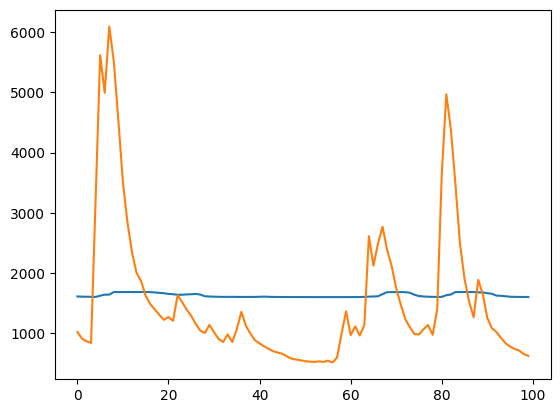

In [334]:
plot_predictions1(model3, X_test1, y_test1)

## Multi-variable

In [335]:
inflow_df = pd.DataFrame({'Inflow':inflow})
inflow_df['Seconds'] = inflow_df.index.map(pd.Timestamp.timestamp)
inflow_df

,Inflow,Seconds
time,,
2002-01-01,1829.75,1.009843e+09
2002-01-02,7279.46,1.009930e+09
2002-01-03,5261.85,1.010016e+09
2002-01-04,2951.97,1.010102e+09
2002-01-05,1868.53,1.010189e+09
...,...,...
2023-12-27,5197.40,1.703635e+09
2023-12-28,6368.46,1.703722e+09
2023-12-29,7162.01,1.703808e+09


In [336]:
day = 24*60*60
year = (365.2425)*day

inflow_df['Rain'] = df['precip_total_daily']
inflow_df['Temp'] = df['temp_mean_daily']
inflow_df['Year sin'] = np.sin(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df['Year cos'] = np.cos(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df = inflow_df.drop('Seconds', axis=1)
inflow_df

,Inflow,Rain,Temp,Year sin,Year cos
time,,,,,
2002-01-01,1829.75,2.2,1.250000,0.004129,0.999991
2002-01-02,7279.46,0.0,-0.837500,0.021330,0.999772
2002-01-03,5261.85,0.0,-5.166667,0.038525,0.999258
2002-01-04,2951.97,0.0,-6.025000,0.055708,0.998447
2002-01-05,1868.53,0.1,-3.466667,0.072875,0.997341
...,...,...,...,...,...
2023-12-27,5197.40,0.0,0.471667,-0.087536,0.996161
2023-12-28,6368.46,0.0,0.255556,-0.070387,0.997520
2023-12-29,7162.01,0.0,0.039444,-0.053217,0.998583


In [337]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [338]:
X2, y2 = df_to_X_y2(inflow_df)
X2.shape, y2.shape

((8029, 6, 5), (8029,))

In [339]:
inflow_df.head()

,Inflow,Rain,Temp,Year sin,Year cos
time,,,,,
2002-01-01,1829.75,2.2,1.250000,0.004129,0.999991
2002-01-02,7279.46,0.0,-0.837500,0.021330,0.999772
2002-01-03,5261.85,0.0,-5.166667,0.038525,0.999258
2002-01-04,2951.97,0.0,-6.025000,0.055708,0.998447
2002-01-05,1868.53,0.1,-3.466667,0.072875,0.997341


In [341]:
X2_train, y2_train = X2[:6000], y2[:6000]
X2_val, y2_val = X2[6000:7000], y2[6000:7000]
X2_test, y2_test = X2[7000:], y2[7000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((6000, 6, 5), (6000,), (1000, 6, 5), (1000,), (1029, 6, 5), (1029,))

### Preprocessing

In [ ]:
# Compute the training statistics from the first channel (inflow) in X2_train
inflow_training_mean = np.mean(X2_train[:, :, 0])
inflow_training_std = np.std(X2_train[:, :, 0])

rain_training_mean = np.mean(X2_train[:, :, 1])
rain_training_std = np.std(X2_train[:, :, 1])

temp_training_mean = np.mean(X2_train[:, :, 2])
temp_training_std = np.std(X2_train[:, :, 2])

# Define the preprocessing functions for features and output
def preprocess(X):
    # Standardize the first three channels (features)
    X[:, :, 0] = (X[:, :, 0] - inflow_training_mean) / inflow_training_std 
    X[:, :, 1] = (X[:, :, 1] - rain_training_mean) / rain_training_std
    X[:, :, 2] = (X[:, :, 2] - temp_training_mean) / temp_training_std 
    return X

def preprocess_output(y):
    # Standardize every element in y
    y[:] = (y[:] - inflow_training_mean) / inflow_training_std
    return y

# Apply preprocessing to all datasets
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)
preprocess_output(y2_train)
preprocess_output(y2_val)
preprocess_output(y2_test)

In [356]:
X2_test.shape , y2_test.shape

((1029, 6, 5), (1029,))

In [357]:
model4 = Sequential()
model4.add(InputLayer((6, 5)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 64)                17920     
                                                                 
 dense_62 (Dense)            (None, 8)                 520       
                                                                 
 dense_63 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18449 (72.07 KB)
Trainable params: 18449 (72.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [363]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [364]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=100, callbacks=[cp4])

Epoch 1/100
170/188 [==========================>...] - ETA: 0s - loss: 387035.2812 - root_mean_squared_error: 622.1216INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 3s 9ms/step - loss: 388956.8438 - root_mean_squared_error: 623.6641 - val_loss: 271913.9062 - val_root_mean_squared_error: 521.4537
Epoch 2/100
177/188 [===========================>..] - ETA: 0s - loss: 371100.0312 - root_mean_squared_error: 609.1798INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 375307.9375 - root_mean_squared_error: 612.6238 - val_loss: 259213.1094 - val_root_mean_squared_error: 509.1298
Epoch 3/100
177/188 [===========================>..] - ETA: 0s - loss: 341428.9062 - root_mean_squared_error: 584.3192INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 338744.8750 - root_mean_squared_error: 582.0179 - val_loss: 209218.0469 - val_root_mean_squared_error: 457.4036
Epoch 4/100
178/188 [===========================>..] - ETA: 0s - loss: 329364.1562 - root_mean_squared_error: 573.9026INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 325793.5000 - root_mean_squared_error: 570.7833 - val_loss: 183051.9375 - val_root_mean_squared_error: 427.8457
Epoch 5/100
178/188 [===========================>..] - ETA: 0s - loss: 327368.6875 - root_mean_squared_error: 572.1614INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 326538.8438 - root_mean_squared_error: 571.4358 - val_loss: 182064.1562 - val_root_mean_squared_error: 426.6898
Epoch 6/100
180/188 [===========================>..] - ETA: 0s - loss: 319173.3438 - root_mean_squared_error: 564.9543INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 322128.2500 - root_mean_squared_error: 567.5634 - val_loss: 172735.7812 - val_root_mean_squared_error: 415.6149
Epoch 7/100
186/188 [============================>.] - ETA: 0s - loss: 308499.7500 - root_mean_squared_error: 555.4276INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 309146.7188 - root_mean_squared_error: 556.0096 - val_loss: 158779.4219 - val_root_mean_squared_error: 398.4713
Epoch 8/100
181/188 [===========================>..] - ETA: 0s - loss: 289220.8438 - root_mean_squared_error: 537.7925INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 2s 13ms/step - loss: 289248.7812 - root_mean_squared_error: 537.8185 - val_loss: 142021.8438 - val_root_mean_squared_error: 376.8578
Epoch 9/100
188/188 [==============================] - 0s 2ms/step - loss: 290721.2500 - root_mean_squared_error: 539.1857 - val_loss: 146242.1719 - val_root_mean_squared_error: 382.4162
Epoch 10/100
158/188 [========================>.....] - ETA: 0s - loss: 289301.5625 - root_mean_squared_error: 537.8676INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 287788.4062 - root_mean_squared_error: 536.4592 - val_loss: 139152.3438 - val_root_mean_squared_error: 373.0313
Epoch 11/100
188/188 [==============================] - 0s 2ms/step - loss: 284039.3125 - root_mean_squared_error: 532.9534 - val_loss: 140276.6562 - val_root_mean_squared_error: 374.5352
Epoch 12/100
185/188 [============================>.] - ETA: 0s - loss: 273451.0000 - root_mean_squared_error: 522.9254INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 275235.4688 - root_mean_squared_error: 524.6289 - val_loss: 122402.4844 - val_root_mean_squared_error: 349.8607
Epoch 13/100
188/188 [==============================] - 0s 2ms/step - loss: 269952.6875 - root_mean_squared_error: 519.5697 - val_loss: 130605.6406 - val_root_mean_squared_error: 361.3940
Epoch 14/100
188/188 [==============================] - 0s 2ms/step - loss: 264774.6875 - root_mean_squared_error: 514.5626 - val_loss: 123661.0000 - val_root_mean_squared_error: 351.6547
Epoch 15/100
188/188 [==============================] - 0s 2ms/step - loss: 264406.7500 - root_mean_squared_error: 514.2050 - val_loss: 125325.9766 - val_root_mean_squared_error: 354.0141
Epoch 16/100
188/188 [==============================] - 0s 2ms/step - loss: 262753.0312 - root_mean_squared_error: 512.5944 - val_loss: 123795.0234 - val_root_mean_squared_error: 351.8452
Epoch 17/100
188/188 [==============================] - 0s 2ms/step - los

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 259717.4375 - root_mean_squared_error: 509.6248 - val_loss: 120037.8438 - val_root_mean_squared_error: 346.4648
Epoch 23/100
188/188 [==============================] - 0s 2ms/step - loss: 255725.3594 - root_mean_squared_error: 505.6930 - val_loss: 131293.2969 - val_root_mean_squared_error: 362.3442
Epoch 24/100
188/188 [==============================] - 0s 2ms/step - loss: 256128.2812 - root_mean_squared_error: 506.0912 - val_loss: 127581.2969 - val_root_mean_squared_error: 357.1852
Epoch 25/100
188/188 [==============================] - 0s 2ms/step - loss: 256720.4844 - root_mean_squared_error: 506.6759 - val_loss: 130893.0391 - val_root_mean_squared_error: 361.7914
Epoch 26/100
188/188 [==============================] - 0s 2ms/step - loss: 253483.8594 - root_mean_squared_error: 503.4718 - val_loss: 128529.0469 - val_root_mean_squared_error: 358.5095
Epoch 27/100
188/188 [==============================] - 0s 2ms/step - los

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 255382.2031 - root_mean_squared_error: 505.3535 - val_loss: 115782.4297 - val_root_mean_squared_error: 340.2682
Epoch 32/100
188/188 [==============================] - 0s 2ms/step - loss: 253647.4062 - root_mean_squared_error: 503.6342 - val_loss: 125211.9141 - val_root_mean_squared_error: 353.8530
Epoch 33/100
188/188 [==============================] - 0s 2ms/step - loss: 250015.9531 - root_mean_squared_error: 500.0160 - val_loss: 124543.5391 - val_root_mean_squared_error: 352.9073
Epoch 34/100
169/188 [=========================>....] - ETA: 0s - loss: 251840.7500 - root_mean_squared_error: 501.8374INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 8ms/step - loss: 250677.6562 - root_mean_squared_error: 500.6772 - val_loss: 111967.7891 - val_root_mean_squared_error: 334.6159
Epoch 35/100
188/188 [==============================] - 0s 2ms/step - loss: 248877.1406 - root_mean_squared_error: 498.8759 - val_loss: 118651.9453 - val_root_mean_squared_error: 344.4589
Epoch 36/100
188/188 [==============================] - 0s 2ms/step - loss: 249150.7344 - root_mean_squared_error: 499.1500 - val_loss: 114002.6484 - val_root_mean_squared_error: 337.6428
Epoch 37/100
188/188 [==============================] - 0s 2ms/step - loss: 251956.4219 - root_mean_squared_error: 501.9526 - val_loss: 121944.4375 - val_root_mean_squared_error: 349.2054
Epoch 38/100
188/188 [==============================] - 0s 2ms/step - loss: 247981.1875 - root_mean_squared_error: 497.9771 - val_loss: 117126.9688 - val_root_mean_squared_error: 342.2382
Epoch 39/100
188/188 [==============================] - 0s 2ms/step - los

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 242581.9375 - root_mean_squared_error: 492.5261 - val_loss: 111774.2109 - val_root_mean_squared_error: 334.3265
Epoch 52/100
188/188 [==============================] - 0s 2ms/step - loss: 240604.5000 - root_mean_squared_error: 490.5145 - val_loss: 121194.5703 - val_root_mean_squared_error: 348.1301
Epoch 53/100
188/188 [==============================] - 0s 2ms/step - loss: 242413.2656 - root_mean_squared_error: 492.3548 - val_loss: 129489.2578 - val_root_mean_squared_error: 359.8462
Epoch 54/100
188/188 [==============================] - 0s 2ms/step - loss: 240597.9375 - root_mean_squared_error: 490.5078 - val_loss: 126011.3828 - val_root_mean_squared_error: 354.9808
Epoch 55/100
188/188 [==============================] - 0s 2ms/step - loss: 238121.1094 - root_mean_squared_error: 487.9765 - val_loss: 123215.9844 - val_root_mean_squared_error: 351.0213
Epoch 56/100
188/188 [==============================] - 0s 2ms/step - los

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 2s 8ms/step - loss: 224065.0312 - root_mean_squared_error: 473.3551 - val_loss: 108863.6250 - val_root_mean_squared_error: 329.9449
Epoch 89/100
188/188 [==============================] - 0s 2ms/step - loss: 229553.0469 - root_mean_squared_error: 479.1169 - val_loss: 118333.6406 - val_root_mean_squared_error: 343.9966
Epoch 90/100
188/188 [==============================] - 0s 2ms/step - loss: 221537.2969 - root_mean_squared_error: 470.6775 - val_loss: 114220.9219 - val_root_mean_squared_error: 337.9659
Epoch 91/100
163/188 [=========================>....] - ETA: 0s - loss: 225610.7031 - root_mean_squared_error: 474.9850INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 222759.5938 - root_mean_squared_error: 471.9742 - val_loss: 107732.4688 - val_root_mean_squared_error: 328.2263
Epoch 92/100
188/188 [==============================] - 0s 2ms/step - loss: 223942.7812 - root_mean_squared_error: 473.2259 - val_loss: 113470.5078 - val_root_mean_squared_error: 336.8539
Epoch 93/100
188/188 [==============================] - 0s 2ms/step - loss: 221137.7969 - root_mean_squared_error: 470.2529 - val_loss: 109421.5078 - val_root_mean_squared_error: 330.7892
Epoch 94/100
188/188 [==============================] - 0s 2ms/step - loss: 221925.8281 - root_mean_squared_error: 471.0901 - val_loss: 115856.2422 - val_root_mean_squared_error: 340.3766
Epoch 95/100
188/188 [==============================] - 0s 2ms/step - loss: 224967.8438 - root_mean_squared_error: 474.3077 - val_loss: 109347.5781 - val_root_mean_squared_error: 330.6775
Epoch 96/100
169/188 [=========================>....] - ETA: 0s - loss: 2

INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 222211.1562 - root_mean_squared_error: 471.3928 - val_loss: 105766.5859 - val_root_mean_squared_error: 325.2177
Epoch 97/100
188/188 [==============================] - 0s 2ms/step - loss: 221068.4844 - root_mean_squared_error: 470.1792 - val_loss: 124689.3281 - val_root_mean_squared_error: 353.1138
Epoch 98/100
188/188 [==============================] - 0s 2ms/step - loss: 221475.6094 - root_mean_squared_error: 470.6119 - val_loss: 118477.2891 - val_root_mean_squared_error: 344.2053
Epoch 99/100
188/188 [==============================] - 0s 2ms/step - loss: 223799.9531 - root_mean_squared_error: 473.0750 - val_loss: 119723.1250 - val_root_mean_squared_error: 346.0103
Epoch 100/100
188/188 [==============================] - 0s 2ms/step - loss: 219462.0781 - root_mean_squared_error: 468.4678 - val_loss: 108787.9453 - val_root_mean_squared_error: 329.8302


33/33 [==============================] - 0s 957us/step


(      Predictions  Actuals
 0     1061.712646   905.19
 1      823.477722   862.98
 2      779.324707   832.00
 3      984.635742  3217.89
 4     6164.103516  5620.73
 ...           ...      ...
 1024  5525.968262  5197.40
 1025  4526.946777  6368.46
 1026  6003.085449  7162.01
 1027  6968.088379  6869.41
 1028  6606.139648  6335.36
 
 [1029 rows x 2 columns],
 383.4664500511948)

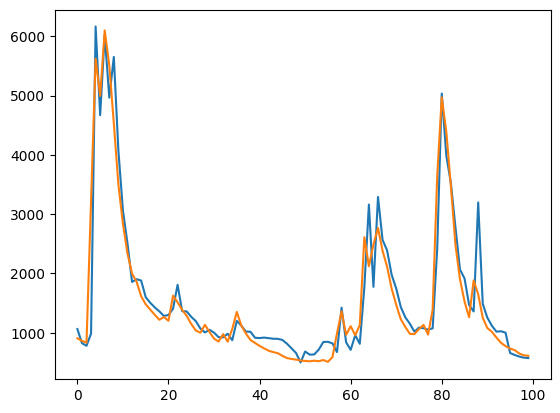

In [365]:
plot_predictions1(model4, X2_test, y2_test)

## LSTM flere lag

In [348]:
model5 = Sequential()
model5.add(InputLayer((6, 5)))
model5.add(LSTM(32, return_sequences=True))
model5.add(LSTM(16))
model5.add(Dense(8, 'relu'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 6, 32)             4864      
                                                                 
 lstm_23 (LSTM)              (None, 16)                3136      
                                                                 
 dense_58 (Dense)            (None, 8)                 136       
                                                                 
 dense_59 (Dense)            (None, 1)                 9         
                                                                 
Total params: 8145 (31.82 KB)
Trainable params: 8145 (31.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [349]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [350]:
model5.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=50, callbacks=[cp5])

Epoch 1/50
177/188 [===========================>..] - ETA: 0s - loss: 5335129.0000 - root_mean_squared_error: 2309.7898INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 4s 14ms/step - loss: 5460483.0000 - root_mean_squared_error: 2336.7676 - val_loss: 5486706.0000 - val_root_mean_squared_error: 2342.3718
Epoch 2/50
166/188 [=========================>....] - ETA: 0s - loss: 5465477.5000 - root_mean_squared_error: 2337.8362INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 5405465.0000 - root_mean_squared_error: 2324.9656 - val_loss: 5425636.5000 - val_root_mean_squared_error: 2329.2996
Epoch 3/50
181/188 [===========================>..] - ETA: 0s - loss: 5331375.5000 - root_mean_squared_error: 2308.9771INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 5331259.5000 - root_mean_squared_error: 2308.9521 - val_loss: 5345444.5000 - val_root_mean_squared_error: 2312.0217
Epoch 4/50
169/188 [=========================>....] - ETA: 0s - loss: 5172725.0000 - root_mean_squared_error: 2274.3625INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 16ms/step - loss: 5235692.5000 - root_mean_squared_error: 2288.1636 - val_loss: 5245778.0000 - val_root_mean_squared_error: 2290.3665
Epoch 5/50
184/188 [============================>.] - ETA: 0s - loss: 5108528.0000 - root_mean_squared_error: 2260.2053INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 5120785.5000 - root_mean_squared_error: 2262.9153 - val_loss: 5129101.5000 - val_root_mean_squared_error: 2264.7520
Epoch 6/50
178/188 [===========================>..] - ETA: 0s - loss: 4980820.0000 - root_mean_squared_error: 2231.7751INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 4989816.0000 - root_mean_squared_error: 2233.7896 - val_loss: 4998772.0000 - val_root_mean_squared_error: 2235.7935
Epoch 7/50
169/188 [=========================>....] - ETA: 0s - loss: 4764847.5000 - root_mean_squared_error: 2182.8530INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 4845567.5000 - root_mean_squared_error: 2201.2649 - val_loss: 4858469.0000 - val_root_mean_squared_error: 2204.1936
Epoch 8/50
183/188 [============================>.] - ETA: 0s - loss: 4726817.0000 - root_mean_squared_error: 2174.1245INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 4691769.0000 - root_mean_squared_error: 2166.0491 - val_loss: 4709939.0000 - val_root_mean_squared_error: 2170.2395
Epoch 9/50
184/188 [============================>.] - ETA: 0s - loss: 4512554.0000 - root_mean_squared_error: 2124.2773INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 4531574.5000 - root_mean_squared_error: 2128.7495 - val_loss: 4559066.5000 - val_root_mean_squared_error: 2135.1970
Epoch 10/50
165/188 [=========================>....] - ETA: 0s - loss: 4433169.5000 - root_mean_squared_error: 2105.5093INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 17ms/step - loss: 4368185.5000 - root_mean_squared_error: 2090.0205 - val_loss: 4406287.5000 - val_root_mean_squared_error: 2099.1160
Epoch 11/50
187/188 [============================>.] - ETA: 0s - loss: 4209374.5000 - root_mean_squared_error: 2051.6760INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 4204135.5000 - root_mean_squared_error: 2050.3989 - val_loss: 4254655.0000 - val_root_mean_squared_error: 2062.6814
Epoch 12/50
183/188 [============================>.] - ETA: 0s - loss: 4034963.5000 - root_mean_squared_error: 2008.7218INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 4042199.0000 - root_mean_squared_error: 2010.5221 - val_loss: 4107028.7500 - val_root_mean_squared_error: 2026.5806
Epoch 13/50
179/188 [===========================>..] - ETA: 0s - loss: 3819727.0000 - root_mean_squared_error: 1954.4122INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 3885282.0000 - root_mean_squared_error: 1971.1118 - val_loss: 3966687.0000 - val_root_mean_squared_error: 1991.6543
Epoch 14/50
181/188 [===========================>..] - ETA: 0s - loss: 3742530.5000 - root_mean_squared_error: 1934.5621INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 3735185.0000 - root_mean_squared_error: 1932.6627 - val_loss: 3833160.7500 - val_root_mean_squared_error: 1957.8459
Epoch 15/50
169/188 [=========================>....] - ETA: 0s - loss: 3645303.0000 - root_mean_squared_error: 1909.2677INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 17ms/step - loss: 3593702.7500 - root_mean_squared_error: 1895.7064 - val_loss: 3709213.2500 - val_root_mean_squared_error: 1925.9318
Epoch 16/50
184/188 [============================>.] - ETA: 0s - loss: 3416174.0000 - root_mean_squared_error: 1848.2894INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 3462390.7500 - root_mean_squared_error: 1860.7500 - val_loss: 3597555.5000 - val_root_mean_squared_error: 1896.7223
Epoch 17/50
168/188 [=========================>....] - ETA: 0s - loss: 3254043.5000 - root_mean_squared_error: 1803.8967INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 3342490.0000 - root_mean_squared_error: 1828.2478 - val_loss: 3496160.7500 - val_root_mean_squared_error: 1869.8024
Epoch 18/50
174/188 [==========================>...] - ETA: 0s - loss: 3188422.0000 - root_mean_squared_error: 1785.6154INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 3234730.0000 - root_mean_squared_error: 1798.5355 - val_loss: 3407694.7500 - val_root_mean_squared_error: 1845.9943
Epoch 19/50
166/188 [=========================>....] - ETA: 0s - loss: 3095309.7500 - root_mean_squared_error: 1759.3492INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 3139581.0000 - root_mean_squared_error: 1771.8862 - val_loss: 3331663.0000 - val_root_mean_squared_error: 1825.2843
Epoch 20/50
168/188 [=========================>....] - ETA: 0s - loss: 3061166.0000 - root_mean_squared_error: 1749.6188INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 3057312.0000 - root_mean_squared_error: 1748.5171 - val_loss: 3267232.7500 - val_root_mean_squared_error: 1807.5488
Epoch 21/50
175/188 [==========================>...] - ETA: 0s - loss: 3041574.2500 - root_mean_squared_error: 1744.0110INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 18ms/step - loss: 2987648.2500 - root_mean_squared_error: 1728.4814 - val_loss: 3214860.7500 - val_root_mean_squared_error: 1793.0033
Epoch 22/50
171/188 [==========================>...] - ETA: 0s - loss: 2898400.7500 - root_mean_squared_error: 1702.4690INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 2929935.0000 - root_mean_squared_error: 1711.7053 - val_loss: 3174466.7500 - val_root_mean_squared_error: 1781.7034
Epoch 23/50
185/188 [============================>.] - ETA: 0s - loss: 2884994.5000 - root_mean_squared_error: 1698.5271INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 2883100.7500 - root_mean_squared_error: 1697.9696 - val_loss: 3142890.0000 - val_root_mean_squared_error: 1772.8198
Epoch 24/50
166/188 [=========================>....] - ETA: 0s - loss: 2832536.2500 - root_mean_squared_error: 1683.0140INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 2846258.0000 - root_mean_squared_error: 1687.0857 - val_loss: 3119825.7500 - val_root_mean_squared_error: 1766.3029
Epoch 25/50
176/188 [===========================>..] - ETA: 0s - loss: 2817405.0000 - root_mean_squared_error: 1678.5127INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 2794277.5000 - root_mean_squared_error: 1671.6093 - val_loss: 2691940.7500 - val_root_mean_squared_error: 1640.7135
Epoch 26/50
169/188 [=========================>....] - ETA: 0s - loss: 2404364.2500 - root_mean_squared_error: 1550.6012INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 17ms/step - loss: 2406335.0000 - root_mean_squared_error: 1551.2366 - val_loss: 2450655.7500 - val_root_mean_squared_error: 1565.4570
Epoch 27/50
185/188 [============================>.] - ETA: 0s - loss: 2249628.7500 - root_mean_squared_error: 1499.8762INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 2250050.5000 - root_mean_squared_error: 1500.0168 - val_loss: 2318569.7500 - val_root_mean_squared_error: 1522.6851
Epoch 28/50
166/188 [=========================>....] - ETA: 0s - loss: 2110744.7500 - root_mean_squared_error: 1452.8402INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 2116271.0000 - root_mean_squared_error: 1454.7408 - val_loss: 2158613.2500 - val_root_mean_squared_error: 1469.2220
Epoch 29/50
167/188 [=========================>....] - ETA: 0s - loss: 1946035.0000 - root_mean_squared_error: 1395.0035INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 1989651.7500 - root_mean_squared_error: 1410.5502 - val_loss: 2031567.3750 - val_root_mean_squared_error: 1425.3306
Epoch 30/50
168/188 [=========================>....] - ETA: 0s - loss: 1841350.8750 - root_mean_squared_error: 1356.9639INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 1879128.6250 - root_mean_squared_error: 1370.8131 - val_loss: 1916440.1250 - val_root_mean_squared_error: 1384.3555
Epoch 31/50
188/188 [==============================] - ETA: 0s - loss: 1771699.5000 - root_mean_squared_error: 1331.0520INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 18ms/step - loss: 1771699.5000 - root_mean_squared_error: 1331.0520 - val_loss: 1795761.2500 - val_root_mean_squared_error: 1340.0602
Epoch 32/50
180/188 [===========================>..] - ETA: 0s - loss: 1675501.1250 - root_mean_squared_error: 1294.4115INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 13ms/step - loss: 1675147.1250 - root_mean_squared_error: 1294.2748 - val_loss: 1685596.7500 - val_root_mean_squared_error: 1298.3053
Epoch 33/50
186/188 [============================>.] - ETA: 0s - loss: 1586349.6250 - root_mean_squared_error: 1259.5037INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 1586496.3750 - root_mean_squared_error: 1259.5620 - val_loss: 1600978.2500 - val_root_mean_squared_error: 1265.2977
Epoch 34/50
166/188 [=========================>....] - ETA: 0s - loss: 1504377.0000 - root_mean_squared_error: 1226.5305INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 1501765.2500 - root_mean_squared_error: 1225.4653 - val_loss: 1488113.2500 - val_root_mean_squared_error: 1219.8824
Epoch 35/50
168/188 [=========================>....] - ETA: 0s - loss: 1475917.7500 - root_mean_squared_error: 1214.8735INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 1421088.1250 - root_mean_squared_error: 1192.0940 - val_loss: 1409542.3750 - val_root_mean_squared_error: 1187.2415
Epoch 36/50
167/188 [=========================>....] - ETA: 0s - loss: 1347805.8750 - root_mean_squared_error: 1160.9504INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 1353689.1250 - root_mean_squared_error: 1163.4814 - val_loss: 1333459.5000 - val_root_mean_squared_error: 1154.7551
Epoch 37/50
168/188 [=========================>....] - ETA: 0s - loss: 1277308.6250 - root_mean_squared_error: 1130.1808INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 18ms/step - loss: 1283179.6250 - root_mean_squared_error: 1132.7751 - val_loss: 1247262.3750 - val_root_mean_squared_error: 1116.8090
Epoch 38/50
166/188 [=========================>....] - ETA: 0s - loss: 1231405.1250 - root_mean_squared_error: 1109.6869INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 1203595.1250 - root_mean_squared_error: 1097.0848 - val_loss: 1164802.8750 - val_root_mean_squared_error: 1079.2604
Epoch 39/50
168/188 [=========================>....] - ETA: 0s - loss: 1162347.8750 - root_mean_squared_error: 1078.1224INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 1148670.5000 - root_mean_squared_error: 1071.7605 - val_loss: 1088438.3750 - val_root_mean_squared_error: 1043.2825
Epoch 40/50
166/188 [=========================>....] - ETA: 0s - loss: 1080654.8750 - root_mean_squared_error: 1039.5455INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 11ms/step - loss: 1088717.0000 - root_mean_squared_error: 1043.4160 - val_loss: 1024501.8750 - val_root_mean_squared_error: 1012.1768
Epoch 41/50
169/188 [=========================>....] - ETA: 0s - loss: 1027139.8750 - root_mean_squared_error: 1013.4791INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 11ms/step - loss: 1040341.3125 - root_mean_squared_error: 1019.9713 - val_loss: 960583.9375 - val_root_mean_squared_error: 980.0938
Epoch 42/50
170/188 [==========================>...] - ETA: 0s - loss: 990935.0625 - root_mean_squared_error: 995.4572  INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 16ms/step - loss: 974421.0625 - root_mean_squared_error: 987.1277 - val_loss: 905106.5625 - val_root_mean_squared_error: 951.3709
Epoch 43/50
187/188 [============================>.] - ETA: 0s - loss: 941170.3750 - root_mean_squared_error: 970.1393INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 941130.5000 - root_mean_squared_error: 970.1188 - val_loss: 849467.8125 - val_root_mean_squared_error: 921.6658
Epoch 44/50
169/188 [=========================>....] - ETA: 0s - loss: 930024.2500 - root_mean_squared_error: 964.3776INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 11ms/step - loss: 897565.8750 - root_mean_squared_error: 947.3995 - val_loss: 792372.8750 - val_root_mean_squared_error: 890.1533
Epoch 45/50
178/188 [===========================>..] - ETA: 0s - loss: 860480.7500 - root_mean_squared_error: 927.6210INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 837111.1250 - root_mean_squared_error: 914.9377 - val_loss: 743992.8125 - val_root_mean_squared_error: 862.5502
Epoch 46/50
187/188 [============================>.] - ETA: 0s - loss: 799637.6250 - root_mean_squared_error: 894.2246INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 801712.0625 - root_mean_squared_error: 895.3837 - val_loss: 721606.6250 - val_root_mean_squared_error: 849.4743
Epoch 47/50
188/188 [==============================] - 0s 2ms/step - loss: 768023.1250 - root_mean_squared_error: 876.3693 - val_loss: 721627.0000 - val_root_mean_squared_error: 849.4863
Epoch 48/50
169/188 [=========================>....] - ETA: 0s - loss: 756571.6250 - root_mean_squared_error: 869.8113INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 12ms/step - loss: 751123.3125 - root_mean_squared_error: 866.6737 - val_loss: 616608.9375 - val_root_mean_squared_error: 785.2445
Epoch 49/50
178/188 [===========================>..] - ETA: 0s - loss: 712635.6250 - root_mean_squared_error: 844.1775INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 3s 17ms/step - loss: 706682.4375 - root_mean_squared_error: 840.6440 - val_loss: 588002.4375 - val_root_mean_squared_error: 766.8132
Epoch 50/50
166/188 [=========================>....] - ETA: 0s - loss: 723621.1250 - root_mean_squared_error: 850.6592INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


188/188 [==============================] - 2s 11ms/step - loss: 718280.8125 - root_mean_squared_error: 847.5145 - val_loss: 564652.1250 - val_root_mean_squared_error: 751.4334


33/33 [==============================] - 0s 1ms/step


(      Predictions  Actuals
 0      941.530457   905.19
 1      932.735229   862.98
 2      924.526428   832.00
 3     1079.452759  3217.89
 4     3611.512695  5620.73
 ...           ...      ...
 1024  4064.503906  5197.40
 1025  4061.443359  6368.46
 1026  4063.649902  7162.01
 1027  4065.179199  6869.41
 1028  4066.297119  6335.36
 
 [1029 rows x 2 columns],
 788.7682734184467)

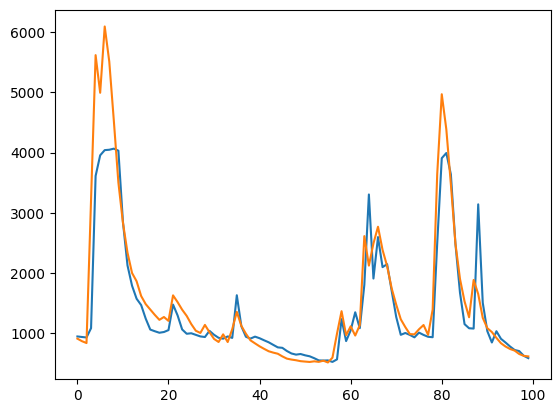

In [351]:
plot_predictions1(model5, X2_test, y2_test)

## Conv1d flere lag

In [352]:
model6 = Sequential()
model6.add(InputLayer((6, 5)))
model6.add(Conv1D(64, kernel_size=2, activation='relu'))
model6.add(Flatten())
model6.add(Dense(8, 'relu'))
model6.add(Dense(1, 'linear'))
model6.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 5, 64)             704       
                                                                 
 flatten_8 (Flatten)         (None, 320)               0         
                                                                 
 dense_60 (Dense)            (None, 8)                 2568      
                                                                 
 dense_61 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3281 (12.82 KB)
Trainable params: 3281 (12.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [353]:
cp6 = ModelCheckpoint('model6/', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [354]:
model6.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=50, callbacks=[cp6])

Epoch 1/50
163/188 [=========================>....] - ETA: 0s - loss: 1194408.2500 - root_mean_squared_error: 1092.8899INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 1s 2ms/step - loss: 1096941.2500 - root_mean_squared_error: 1047.3496 - val_loss: 307388.3438 - val_root_mean_squared_error: 554.4261
Epoch 2/50
 97/188 [==============>...............] - ETA: 0s - loss: 423594.7188 - root_mean_squared_error: 650.8416INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 409480.9688 - root_mean_squared_error: 639.9070 - val_loss: 283399.9375 - val_root_mean_squared_error: 532.3532
Epoch 3/50
 94/188 [==============>...............] - ETA: 0s - loss: 372996.3125 - root_mean_squared_error: 610.7343INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 350605.0625 - root_mean_squared_error: 592.1191 - val_loss: 166183.2188 - val_root_mean_squared_error: 407.6558
Epoch 4/50
 96/188 [==============>...............] - ETA: 0s - loss: 369377.7188 - root_mean_squared_error: 607.7645INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 334996.9375 - root_mean_squared_error: 578.7892 - val_loss: 163102.5469 - val_root_mean_squared_error: 403.8596
Epoch 5/50
188/188 [==============================] - 0s 642us/step - loss: 321154.1875 - root_mean_squared_error: 566.7047 - val_loss: 179261.3438 - val_root_mean_squared_error: 423.3927
Epoch 6/50
188/188 [==============================] - 0s 683us/step - loss: 320609.4062 - root_mean_squared_error: 566.2238 - val_loss: 178575.4688 - val_root_mean_squared_error: 422.5819
Epoch 7/50
 98/188 [==============>...............] - ETA: 0s - loss: 332186.5625 - root_mean_squared_error: 576.3563INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 317925.6250 - root_mean_squared_error: 563.8489 - val_loss: 151713.5000 - val_root_mean_squared_error: 389.5042
Epoch 8/50
188/188 [==============================] - 0s 636us/step - loss: 318579.8750 - root_mean_squared_error: 564.4288 - val_loss: 157040.4688 - val_root_mean_squared_error: 396.2833
Epoch 9/50
 96/188 [==============>...............] - ETA: 0s - loss: 306206.4688 - root_mean_squared_error: 553.3593INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 311198.3438 - root_mean_squared_error: 557.8516 - val_loss: 147151.7500 - val_root_mean_squared_error: 383.6036
Epoch 10/50
188/188 [==============================] - 0s 640us/step - loss: 305793.0312 - root_mean_squared_error: 552.9855 - val_loss: 154871.8906 - val_root_mean_squared_error: 393.5377
Epoch 11/50
188/188 [==============================] - 0s 646us/step - loss: 302369.7812 - root_mean_squared_error: 549.8816 - val_loss: 161474.6875 - val_root_mean_squared_error: 401.8391
Epoch 12/50
188/188 [==============================] - 0s 650us/step - loss: 303901.5625 - root_mean_squared_error: 551.2727 - val_loss: 163416.0938 - val_root_mean_squared_error: 404.2476
Epoch 13/50
188/188 [==============================] - 0s 636us/step - loss: 303235.6562 - root_mean_squared_error: 550.6684 - val_loss: 149669.6562 - val_root_mean_squared_error: 386.8716
Epoch 14/50
188/188 [==============================] - 0s 638us/step 

INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 288003.4688 - root_mean_squared_error: 536.6595 - val_loss: 127447.1406 - val_root_mean_squared_error: 356.9974
Epoch 19/50
188/188 [==============================] - 0s 652us/step - loss: 280638.5938 - root_mean_squared_error: 529.7534 - val_loss: 132932.0312 - val_root_mean_squared_error: 364.5984
Epoch 20/50
 97/188 [==============>...............] - ETA: 0s - loss: 274096.6875 - root_mean_squared_error: 523.5424INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 282720.8438 - root_mean_squared_error: 531.7150 - val_loss: 126526.2344 - val_root_mean_squared_error: 355.7053
Epoch 21/50
100/188 [==============>...............] - ETA: 0s - loss: 280021.4688 - root_mean_squared_error: 529.1705INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 275210.9688 - root_mean_squared_error: 524.6055 - val_loss: 126211.7031 - val_root_mean_squared_error: 355.2629
Epoch 22/50
186/188 [============================>.] - ETA: 0s - loss: 271615.5625 - root_mean_squared_error: 521.1675INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 270554.0625 - root_mean_squared_error: 520.1481 - val_loss: 122586.3281 - val_root_mean_squared_error: 350.1233
Epoch 23/50
188/188 [==============================] - 0s 785us/step - loss: 274186.8438 - root_mean_squared_error: 523.6285 - val_loss: 124240.3125 - val_root_mean_squared_error: 352.4774
Epoch 24/50
168/188 [=========================>....] - ETA: 0s - loss: 277983.9375 - root_mean_squared_error: 527.2418INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 273049.2500 - root_mean_squared_error: 522.5411 - val_loss: 115191.5625 - val_root_mean_squared_error: 339.3988
Epoch 25/50
188/188 [==============================] - 0s 641us/step - loss: 263995.8125 - root_mean_squared_error: 513.8052 - val_loss: 152945.4219 - val_root_mean_squared_error: 391.0824
Epoch 26/50
188/188 [==============================] - 0s 624us/step - loss: 262727.2812 - root_mean_squared_error: 512.5693 - val_loss: 121932.8672 - val_root_mean_squared_error: 349.1889
Epoch 27/50
188/188 [==============================] - 0s 626us/step - loss: 261308.7500 - root_mean_squared_error: 511.1837 - val_loss: 116061.1250 - val_root_mean_squared_error: 340.6775
Epoch 28/50
 98/188 [==============>...............] - ETA: 0s - loss: 238843.5938 - root_mean_squared_error: 488.7163INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 255072.4688 - root_mean_squared_error: 505.0470 - val_loss: 114886.8906 - val_root_mean_squared_error: 338.9497
Epoch 29/50
100/188 [==============>...............] - ETA: 0s - loss: 251453.4219 - root_mean_squared_error: 501.4513INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 255460.3906 - root_mean_squared_error: 505.4309 - val_loss: 106284.9062 - val_root_mean_squared_error: 326.0137
Epoch 30/50
188/188 [==============================] - 0s 624us/step - loss: 249798.2344 - root_mean_squared_error: 499.7982 - val_loss: 109096.2266 - val_root_mean_squared_error: 330.2972
Epoch 31/50
188/188 [==============================] - 0s 626us/step - loss: 246873.7500 - root_mean_squared_error: 496.8639 - val_loss: 109105.4219 - val_root_mean_squared_error: 330.3111
Epoch 32/50
188/188 [==============================] - 0s 614us/step - loss: 248259.6094 - root_mean_squared_error: 498.2566 - val_loss: 106656.7422 - val_root_mean_squared_error: 326.5834
Epoch 33/50
188/188 [==============================] - 0s 631us/step - loss: 246531.8750 - root_mean_squared_error: 496.5198 - val_loss: 107970.3516 - val_root_mean_squared_error: 328.5884
Epoch 34/50
188/188 [==============================] - 0s 666us/step 

INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 241316.0469 - root_mean_squared_error: 491.2393 - val_loss: 105559.8203 - val_root_mean_squared_error: 324.8997
Epoch 36/50
100/188 [==============>...............] - ETA: 0s - loss: 263042.7812 - root_mean_squared_error: 512.8770INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 242997.8594 - root_mean_squared_error: 492.9481 - val_loss: 102314.7734 - val_root_mean_squared_error: 319.8668
Epoch 37/50
100/188 [==============>...............] - ETA: 0s - loss: 244536.8750 - root_mean_squared_error: 494.5067INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 234767.6562 - root_mean_squared_error: 484.5283 - val_loss: 98961.8281 - val_root_mean_squared_error: 314.5820
Epoch 38/50
188/188 [==============================] - 0s 642us/step - loss: 234406.0938 - root_mean_squared_error: 484.1550 - val_loss: 112837.9219 - val_root_mean_squared_error: 335.9136
Epoch 39/50
 95/188 [==============>...............] - ETA: 0s - loss: 227839.1719 - root_mean_squared_error: 477.3250INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 236399.1875 - root_mean_squared_error: 486.2090 - val_loss: 95856.7969 - val_root_mean_squared_error: 309.6075
Epoch 40/50
188/188 [==============================] - 0s 626us/step - loss: 234908.0469 - root_mean_squared_error: 484.6731 - val_loss: 101991.7500 - val_root_mean_squared_error: 319.3615
Epoch 41/50
188/188 [==============================] - 0s 625us/step - loss: 228360.5469 - root_mean_squared_error: 477.8708 - val_loss: 109492.3125 - val_root_mean_squared_error: 330.8962
Epoch 42/50
188/188 [==============================] - 0s 640us/step - loss: 229727.6406 - root_mean_squared_error: 479.2991 - val_loss: 99583.9375 - val_root_mean_squared_error: 315.5692
Epoch 43/50
188/188 [==============================] - 0s 691us/step - loss: 224511.6094 - root_mean_squared_error: 473.8266 - val_loss: 113379.6641 - val_root_mean_squared_error: 336.7190
Epoch 44/50
188/188 [==============================] - 0s 644us/step - 

INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 226150.3125 - root_mean_squared_error: 475.5526 - val_loss: 93930.5547 - val_root_mean_squared_error: 306.4809
Epoch 47/50
188/188 [==============================] - 0s 626us/step - loss: 227189.4688 - root_mean_squared_error: 476.6440 - val_loss: 96832.0234 - val_root_mean_squared_error: 311.1784
Epoch 48/50
188/188 [==============================] - 0s 621us/step - loss: 223639.0625 - root_mean_squared_error: 472.9049 - val_loss: 121983.9531 - val_root_mean_squared_error: 349.2620
Epoch 49/50
115/188 [=================>............] - ETA: 0s - loss: 227390.2031 - root_mean_squared_error: 476.8545INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


188/188 [==============================] - 0s 2ms/step - loss: 224352.6875 - root_mean_squared_error: 473.6588 - val_loss: 89880.5156 - val_root_mean_squared_error: 299.8008
Epoch 50/50
188/188 [==============================] - 0s 644us/step - loss: 218099.0312 - root_mean_squared_error: 467.0107 - val_loss: 118855.9609 - val_root_mean_squared_error: 344.7549


33/33 [==============================] - 0s 408us/step


(      Predictions  Actuals
 0     1128.971191   905.19
 1      845.308777   862.98
 2      937.047668   832.00
 3     1399.216797  3217.89
 4     5050.986328  5620.73
 ...           ...      ...
 1024  5912.481934  5197.40
 1025  5197.646973  6368.46
 1026  7338.716797  7162.01
 1027  7625.065918  6869.41
 1028  6910.046387  6335.36
 
 [1029 rows x 2 columns],
 387.2098462536785)

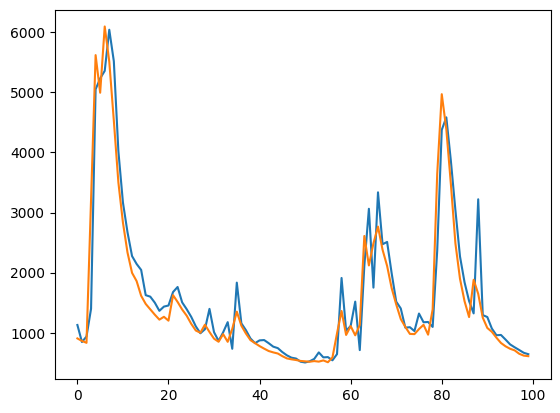

In [355]:
plot_predictions1(model6, X2_test, y2_test)